In [4]:
#Imports
import pandas as pd
import os
import tensorflow as tf

from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *

#Get data 
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/df_with_final_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)

df_array = []
for idx in range(5):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

#df_array[3].head(3)

#Train, Validation and Test datasets
sequence_length = 25
batch_size = 16
num_features = df_array[0].shape[1]

dh = Datahandler()

X_train, y_train, X_val, y_val, X_test, y_test = {}, {}, {}, {}, {}, {}

#Create Train, Validation and Test datasets
for idx, df in enumerate(df_array):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min max sclaing
    train_df = dh.min_max_scaling(train_df)
    val_df = dh.min_max_scaling(val_df)
    test_df = dh.min_max_scaling(test_df)

    # Sequencing
    train_sequences = dh.create_sequences(train_df, sequence_length)
    val_sequences = dh.create_sequences(val_df, sequence_length)
    test_sequences = dh.create_sequences(test_df, sequence_length)

    #Split into feature and label
    X_train[f'user{idx+1}'], y_train[f'user{idx+1}'] = dh.prepare_data(train_sequences, batch_size)
    X_val[f'user{idx+1}'], y_val[f'user{idx+1}'] = dh.prepare_data(val_sequences, batch_size)
    X_test[f'user{idx+1}'], y_test[f'user{idx+1}'] = dh.prepare_data(test_sequences, batch_size)
    

X_train = np.vstack(list(X_train.values()))
y_train = np.vstack(list(y_train.values()))
y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1])

X_val = np.vstack(list(X_val.values()))
y_val = np.vstack(list(y_val.values()))
y_val = y_val.reshape(y_val.shape[0]*y_val.shape[1])

X_test = np.vstack(list(X_test.values()))
y_test = np.vstack(list(y_test.values()))
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1])

#General Hyperparameters
# #All models
horizon = 1
max_epochs = 100
m1 = ModelGenerator()
mh = Modelhandler()

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()
#model_checkpoint = ModelCheckpoint('models/best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks=[early_stopping, timing_callback, custom_callback] #model_checkpoint


# Dense Model

In [6]:
dense_results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse','mse_std', 'rmse','rmse_std','mape','mape_std','mae','mae_std'])

In [7]:
def build_dense_model(X_train, horizon, num_layers, units, batch_size):

    input_data = layers.Input(shape=(X_train.shape[1], X_train.shape[2]), batch_size=batch_size) 
    x =  layers.Dense(units, activation='relu')(input_data)
    for _ in range(num_layers-1):
      x = layers.Dense(units, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    output = layers.Dense(horizon)(x) 

    dense_model = tf.keras.Model(inputs=input_data, outputs=output, name="Dense_model")

    return dense_model

In [11]:
#Dense Model

#Dense Hyperparameter
dense_architecture = "L3_U16"
dense_layers = 3
dense_units = 16
dense_all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

#For each of the 3 user
for round in range(3):
    #print("Round: ", round)
    dense_model = build_dense_model(X_train, horizon, num_layers=dense_layers, units=dense_units, batch_size=batch_size)
    dense_histroy, dense_user_results = mh.compile_fit_evaluate_model(
        model=dense_model, 
        loss=loss, 
        metrics=metrics, 
        X_train=X_train,
        y_train = y_train, 
        max_epochs = max_epochs, 
        batch_size=batch_size, 
        X_val=X_val, 
        y_val=y_val, 
        X_test=X_test, 
        y_test=y_test, 
        callbacks=callbacks, 
        user=f'User{round+1}', 
        hyper=dense_architecture,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )
    # Add the 'architecture' column from dense_user_results to dense_results
    dense_all_results = pd.merge(dense_all_results, dense_user_results, how='outer')

In [12]:
dense_all_results

,user,architecture,train_time,avg_time_epoch,mse,rmse,mape,mae
0,User1,L3_U16,33.487962,1.513861,0.021594,0.146948,138185.359375,0.085483
1,User2,L3_U16,39.389549,1.633127,0.021419,0.146352,134740.828125,0.091723
2,User3,L3_U16,42.786802,1.638185,0.021004,0.144927,135959.125000,0.086602


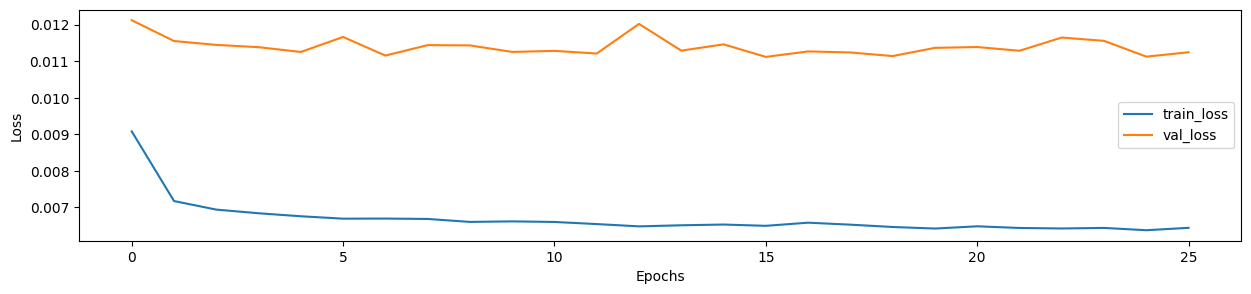

260/260 [==============================] - 0s 533us/step


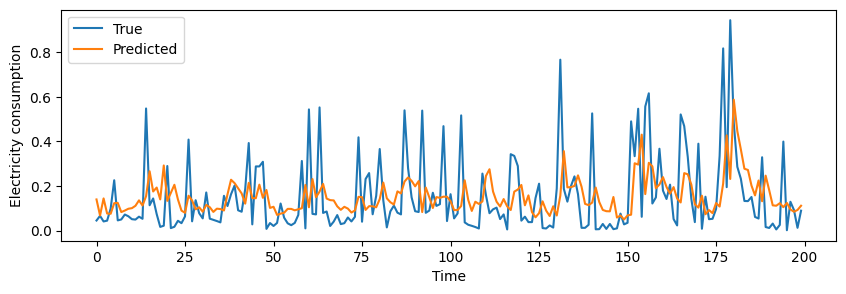

In [13]:
mh.plot_model_predictions(dense_model, dense_histroy, y_test, X_test, batch_size)

In [14]:
new_row = {
    'architecture': dense_all_results["architecture"][0],
    'train_time': dense_all_results["train_time"].mean(), 
    'avg_time_epoch' : dense_all_results["avg_time_epoch"].mean(),
    'mse': dense_all_results["mse"].mean(),
    'mse_std' : dense_all_results["mse"].std(),
    'rmse': dense_all_results["rmse"].mean(),
    'rmse_std' : dense_all_results["rmse"].std(),
    'mape': dense_all_results["mape"].mean(),
    'mape_std' : dense_all_results["mape"].std(),
    'mae': dense_all_results["mae"].mean(),
    'mae_std' : dense_all_results["mae"].std(),
}
dense_results.loc[len(dense_results)] = new_row

In [15]:
print("Mean total train time: ", dense_results["train_time"].mean())
print("Mean train time epoch: ", dense_results["avg_time_epoch"].mean())
print("Mean mse: ", dense_results["mse"].mean())
print("Mean rmse: ", dense_results["rmse"].mean())
print("Mean mape: ", dense_results["mape"].mean())
print("Mean mae: ", dense_results["mae"].mean())

Mean total train time:  38.55477078755697
Mean train time epoch:  1.5950575189805345
Mean mse:  0.021338912347952526
Mean rmse:  0.14607598384221396
Mean mape:  136295.10416666666
Mean mae:  0.08793572088082631


# Mixture of experts dense model

In [33]:
dense_moe_results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse','mse_std', 'rmse','rmse_std','mape','mape_std','mae','mae_std'])

In [40]:
#Builds the expert models for the MoE Layer
def build_expert_network(expert_units):
    expert = keras.Sequential([
            layers.Dense(expert_units, activation="relu"), 
            layers.Dense(expert_units, activation="relu"), 
            ])
    return expert


#Builds a MoE model with top_k gating
def build_topk_dense_moe_model(X_train, batch_size, horizon, dense_units, num_experts, top_k, expert_units, m1):
    #Input of shape (batch_size, sequence_length, features)
    inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]), batch_size=batch_size, name='input_layer') 
    x = layers.Dense(dense_units, activation="relu")(inputs)
    

    #EMBEDDED MOE LAYER
    # ROUTER
    router_inputs = x
    router_probs = layers.Dense(num_experts, activation='softmax')(router_inputs)
    expert_gate, expert_index = tf.math.top_k(router_probs, k=top_k)
    expert_idx_mask = tf.one_hot(expert_index, depth=num_experts)
    combined_tensor = tf.einsum('abc,abcd->abd', expert_gate, expert_idx_mask)
    expert_inputs = tf.einsum("abc,abd->dabc", router_inputs, combined_tensor) # Instead of (3,4) -> (3, 16, 24, 4)
    expert_input_list = tf.unstack(expert_inputs, axis=0)
    expert_output_list = [
            [build_expert_network(expert_units=expert_units) for _ in range(num_experts)][idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]
    expert_outputs = tf.stack(expert_output_list, axis=1)
    expert_outputs_combined = tf.einsum(
            "abcd,ace->acd", expert_outputs, combined_tensor #(16, 2, 24, 4) and (16, 24, 3)
        )    
    moe_output = expert_outputs_combined
    #END MOE LAYER

    #BOTTOM Model
    x = layers.Dropout(0.2)(moe_output)
    x = layers.Flatten()(x)
    outputs = layers.Dense(horizon)(x)
    topk_moe_model = models.Model(inputs=inputs, outputs=outputs, name="topk_moe")

    return topk_moe_model

In [41]:
#Dense Model

#Dense Hyperparameter
dense_moe_architecture = "top2_exp5_d8" #top2_exp5_d8
dense_moe_units = 16

num_experts = 5
expert_units = 16
top_k = 1

dense_moe_all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

#For each of the 3 user
for round in range(3):
    #print("Round: ", round)
    dense_moe_model = build_topk_dense_moe_model(X_train, batch_size, horizon, dense_moe_units, num_experts, top_k, expert_units, m1)
    dense_moe_histroy, dense_moe_user_results = mh.compile_fit_evaluate_model(
        model=dense_moe_model, 
        loss=loss, 
        metrics=metrics, 
        X_train=X_train,
        y_train = y_train, 
        max_epochs = max_epochs, 
        batch_size=batch_size, 
        X_val=X_val, 
        y_val=y_val, 
        X_test=X_test, 
        y_test=y_test, 
        callbacks=callbacks, 
        user=f'User{round+1}', 
        hyper=dense_moe_architecture,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )
    # Add the 'architecture' column from dense_user_results to dense_results
    dense_moe_all_results = pd.merge(dense_moe_all_results, dense_moe_user_results, how='outer')

In [42]:
dense_moe_all_results

,user,architecture,train_time,avg_time_epoch,mse,rmse,mape,mae
0,User1,top2_exp5_d8,70.048785,3.487308,0.021270,0.145843,112957.171875,0.083829
1,User2,top2_exp5_d8,146.322311,3.395255,0.021456,0.146478,127827.976562,0.084765
2,User3,top2_exp5_d8,87.007893,3.334456,0.021222,0.145679,149142.937500,0.088294


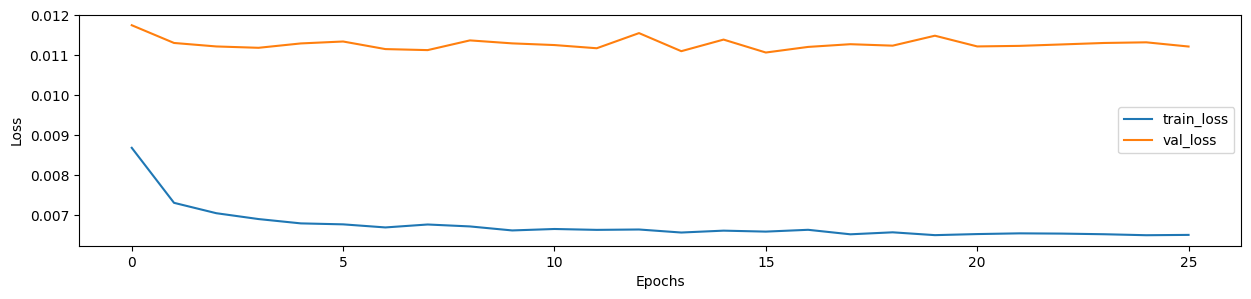

260/260 [==============================] - 0s 978us/step


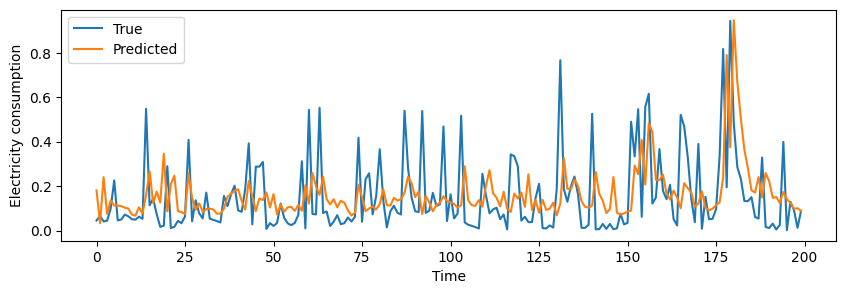

In [43]:
mh.plot_model_predictions(dense_moe_model, dense_moe_histroy, y_test, X_test, batch_size)

In [44]:
new_row = {
    'architecture': dense_moe_all_results["architecture"][0],
    'train_time': dense_moe_all_results["train_time"].mean(), 
    'avg_time_epoch' : dense_moe_all_results["avg_time_epoch"].mean(),
    'mse': dense_moe_all_results["mse"].mean(),
    'mse_std' : dense_moe_all_results["mse"].std(),
    'rmse': dense_moe_all_results["rmse"].mean(),
    'rmse_std' : dense_moe_all_results["rmse"].std(),
    'mape': dense_moe_all_results["mape"].mean(),
    'mape_std' : dense_moe_all_results["mape"].std(),
    'mae': dense_moe_all_results["mae"].mean(),
    'mae_std' : dense_moe_all_results["mae"].std(),
}
dense_moe_results.loc[len(dense_moe_results)] = new_row

In [45]:
print("Dense ------------------------------------------------")
print("Mean total train time: ", dense_results["train_time"].mean())
print("Mean train time epoch: ", dense_results["avg_time_epoch"].mean())
print("Mean mse: ", dense_results["mse"].mean())
print("Mean rmse: ", dense_results["rmse"].mean())
print("Mean mape: ", dense_results["mape"].mean())
print("Mean mae: ", dense_results["mae"].mean())

print("Mixture of Experts Dense ------------------------------------------------")
print("Mean total train time: ", dense_moe_results["train_time"].mean())
print("Mean train time epoch: ", dense_moe_results["avg_time_epoch"].mean())
print("Mean mse: ", dense_moe_results["mse"].mean())
print("Mean rmse: ", dense_moe_results["rmse"].mean())
print("Mean mape: ", dense_moe_results["mape"].mean())
print("Mean mae: ", dense_moe_results["mae"].mean())

Dense ------------------------------------------------
Mean total train time:  38.55477078755697
Mean train time epoch:  1.5950575189805345
Mean mse:  0.021338912347952526
Mean rmse:  0.14607598384221396
Mean mape:  136295.10416666666
Mean mae:  0.08793572088082631
Mixture of Experts Dense ------------------------------------------------
Mean total train time:  88.57789516448975
Mean train time epoch:  3.1432327524790815
Mean mse:  0.021476356002191704
Mean rmse:  0.14654414852460224
Mean mape:  124285.15364583333
Mean mae:  0.08422728379567465
